# Live #73 - Análise de Dados para Logística

### Demonstração: Otimização de Rotas usando Google Maps API e Pulp

In [76]:
API_KEY = 'api do google maps' # Crie a sua com a demonstração de 90 dias em https://developers.google.com/maps?hl=pt-br

In [77]:
# Lembre-se de instalar as bibliotecas que não tem em seu ambiente usando "pip install NOME_DO_PACOTE"

import numpy as np
import pandas as pd
import pulp
import gmaps
import googlemaps
import time
import itertools
import matplotlib.pyplot as plt


gmaps.configure(api_key=API_KEY)
googlemaps_client = googlemaps.Client(key=API_KEY)


# Obter coordenadas dos endereços
def get_coordinates(address):
    geocode_result = googlemaps_client.geocode(address)
    location = geocode_result[0]['geometry']['location']
    return location['lat'], location['lng']


# Função para calcular a distância entre dois pontos
def distance_calculator(df):
    distance_result = np.zeros((len(df), len(df)))
    lat_lon = df.apply(lambda row: f"{row['latitude']},{row['longitude']}", axis=1)

    for i, origin in enumerate(lat_lon):
        for j, destination in enumerate(lat_lon):
            if i != j:
                try:
                    result = googlemaps_client.directions(origin, destination, mode='driving')
                    if result:
                        distance_result[i][j] = result[0]['legs'][0]['distance']['value']
                    else:
                        distance_result[i][j] = np.inf  # Se não houver resultado, defina a distância como infinita
                except Exception as e:
                    print(f"Erro ao calcular distância de {origin} para {destination}: {e}")
                    distance_result[i][j] = np.inf
            else:
                distance_result[i][j] = 0
            time.sleep(1)  # Adicionar um atraso para evitar exceder o limite de taxa da API
    return distance_result


In [78]:
# exemplo do que a API do Google retorna
googlemaps_client.geocode("R. Dom Pedro Silva, 263")

[{'address_components': [{'long_name': '263',
    'short_name': '263',
    'types': ['street_number']},
   {'long_name': 'Rua Dom Pedro Silva',
    'short_name': 'R. Dom Pedro Silva',
    'types': ['route']},
   {'long_name': 'Vila Gumercindo',
    'short_name': 'Vila Gumercindo',
    'types': ['political', 'sublocality', 'sublocality_level_1']},
   {'long_name': 'São Paulo',
    'short_name': 'São Paulo',
    'types': ['administrative_area_level_2', 'political']},
   {'long_name': 'São Paulo',
    'short_name': 'SP',
    'types': ['administrative_area_level_1', 'political']},
   {'long_name': 'Brazil',
    'short_name': 'BR',
    'types': ['country', 'political']},
   {'long_name': '04129-050',
    'short_name': '04129-050',
    'types': ['postal_code']}],
  'formatted_address': 'R. Dom Pedro Silva, 263 - Vila Gumercindo, São Paulo - SP, 04129-050, Brazil',
  'geometry': {'location': {'lat': -23.6042026, 'lng': -46.6224423},
   'location_type': 'RANGE_INTERPOLATED',
   'viewport': {'n

In [79]:
# capacidade da frota
vehicle_count = 3

# capacidade do veículo
vehicle_capacity = 50


# Endereços dos clientes (o primeiro é o depósito)
addresses = [
    "R. Dom Pedro Silva, 263",  # Substitua pelo endereço do depósito
    "R. Visc. de Guaratiba, 195 - Cursino, São Paulo - SP, 04125-040", # Substitua pelo endereço do cliente 1
    "Rua Vergueiro, 5917"
]

# número de clientes
customer_count = len(addresses)

# Inicializar listas para armazenar coordenadas e demandas
latitudes = []
longitudes = []
demands = [0]  # Demanda do depósito é 0

# Obter coordenadas para todos os endereços
for address in addresses:
    lat, lng = get_coordinates(address)
    if lat is not None and lng is not None:
        latitudes.append(lat)
        longitudes.append(lng)
    else:
        print(f"Pulei o endereço: {address}")

In [80]:
# Gerar demandas aleatórias para os clientes (exceto o depósito) - Apenas para essa demonstração
demands.extend(np.random.randint(10, 20, len(addresses) - 1))

# Criar DataFrame com localizações e demandas
df = pd.DataFrame({
    "latitude": latitudes,
    "longitude": longitudes,
    "demand": demands,
    "enderecos":addresses
})

In [81]:
df

,latitude,longitude,demand,enderecos
0,-23.604203,-46.622442,0,"R. Dom Pedro Silva, 263"
1,-23.599617,-46.619094,11,"R. Visc. de Guaratiba, 195 - Cursino, São Paul..."
2,-23.597937,-46.615701,17,"Rua Vergueiro, 5917"


In [82]:
# calcula as distâncias de cada endereço um a um
distance = distance_calculator(df)
distance

array([[   0.,  842., 1457.],
       [1120.,    0.,  613.],
       [1533.,  603.,    0.]])

Vehicle Requirements: 1
Moving Distance: 2988.0


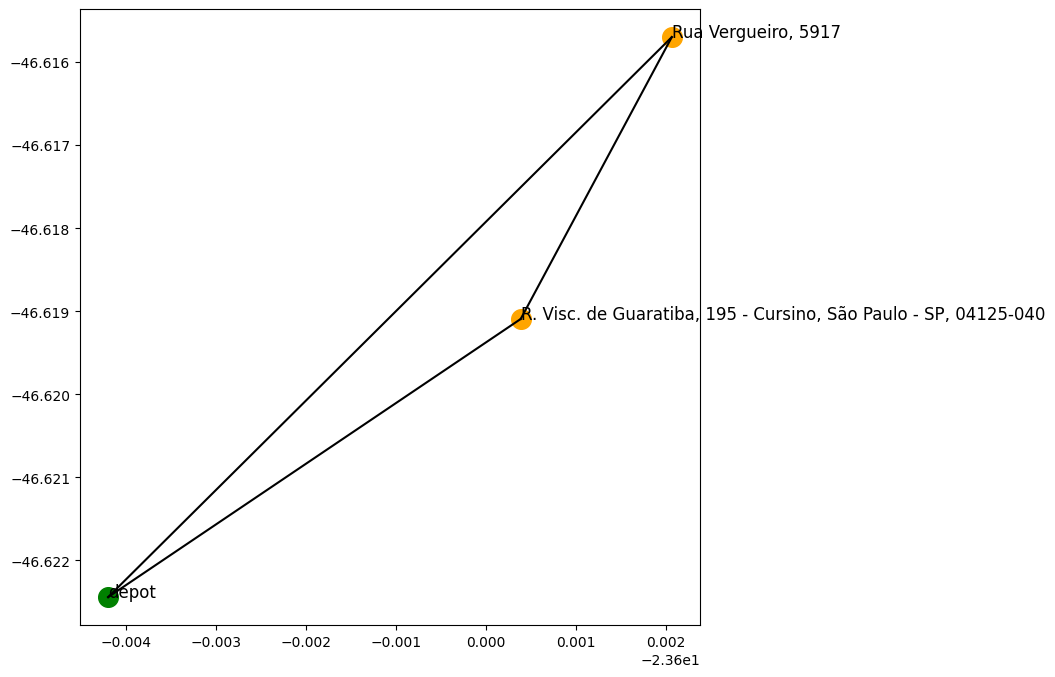

In [83]:
# Resolve o problema de otimização
for vehicle_count in range(1,vehicle_count+1):

    # Define o problema de otimização (LpProblem)
    problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

    x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(vehicle_count)]for j in range(customer_count)] for i in range(customer_count)]

    #(1) função objetivo que significa “minimizar o custo de viagem (soma da distância percorrida) de todos os veículos”
    problem += pulp.lpSum(distance[i][j] * x[i][j][k] if i != j else 0
                          for k in range(vehicle_count)
                          for j in range(customer_count)
                          for i in range (customer_count))

    # Restrições do problema

    #(2) restrição que significa “apenas uma visita por veículo e por localização do cliente”

    for j in range(1, customer_count):
        problem += pulp.lpSum(x[i][j][k] if i != j else 0
                              for i in range(customer_count)
                              for k in range(vehicle_count)) == 1

    #(3) restrição que significa “saída do depósito”

    for k in range(vehicle_count):
        problem += pulp.lpSum(x[0][j][k] for j in range(1,customer_count)) == 1
        problem += pulp.lpSum(x[i][0][k] for i in range(1,customer_count)) == 1

    #(4) restrição que significa que “o número de veículos que entram e saem da localização de um cliente é o mesmo”

    for k in range(vehicle_count):
        for j in range(customer_count):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                  for i in range(customer_count)) -  pulp.lpSum(x[j][i][k] for i in range(customer_count)) == 0

    #(5) restrição que significa que “a capacidade de entrega de cada veículo não deve exceder a capacidade máxima”
    for k in range(vehicle_count):
        problem += pulp.lpSum(df.demand[j] * x[i][j][k] if i != j else 0 for i in range(customer_count) for j in range (1,customer_count)) <= vehicle_capacity


    #(6) restrição para “remoção de subtours”
    subtours = []
    for i in range(2,customer_count):
         subtours += itertools.combinations(range(1,customer_count), i)

    for s in subtours:
        problem += pulp.lpSum(x[i][j][k] if i !=j else 0 for i, j in itertools.permutations(s,2) for k in range(vehicle_count)) <= len(s) - 1


    if problem.solve() == 1:
        print('Vehicle Requirements:', vehicle_count) # Mostra a quantidade de veículos necessárias
        print('Moving Distance:', pulp.value(problem.objective)) # Mostra a distância ótima a ser percorrida
        break


# visualization : plotting on google maps
fig = gmaps.figure()
layer = []
color_list = ["red","blue","green"]

for k in range(vehicle_count):
    for i in range(customer_count):
        for j in range(customer_count):
            if i != j and pulp.value(x[i][j][k]) == 1:
                layer.append(gmaps.directions.Directions(
                    (df.latitude[i],df.longitude[i]),
                    (df.latitude[j],df.longitude[j]),
                    mode='car',stroke_color=color_list[k],stroke_opacity=1.0, stroke_weight=5.0))

for i in range(len(layer)):
    fig.add_layer(layer[i])

fig


# visualization : plotting with matplolib
plt.figure(figsize=(8,8))
for i in range(customer_count):
    if i == 0:
        plt.scatter(df.latitude[i], df.longitude[i], c='green', s=200)
        plt.text(df.latitude[i], df.longitude[i], "depot", fontsize=12)
    else:
        plt.scatter(df.latitude[i], df.longitude[i], c='orange', s=200)
        plt.text(df.latitude[i], df.longitude[i], str(df.enderecos[i]), fontsize=12)

for k in range(vehicle_count):
    for i in range(customer_count):
        for j in range(customer_count):
            if i != j and pulp.value(x[i][j][k]) == 1:
                plt.plot([df.latitude[i], df.latitude[j]], [df.longitude[i], df.longitude[j]], c="black")

plt.show()